<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
pip install plot-metric

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
# импортируем библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.templates.default = "seaborn"

import re
import statistics
import sklearn.metrics as metrics
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from plot_metric.functions import BinaryClassification
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', -1)

In [3]:
#Изучим данные
df = pd.read_csv('/datasets/Churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
df.tail()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1
9999,10000,15628319,Walker,792,France,Female,28,NaN,130142.79,1,1,0,38190.78,0


In [5]:
# с помощью метода info() изучим типы данных, количество строк, столбцов, пропущенных данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Датафрейм содержит пропуски

In [6]:
#посмотрим количество пропусков
df.isna().sum()

RowNumber          0  
CustomerId         0  
Surname            0  
CreditScore        0  
Geography          0  
Gender             0  
Age                0  
Tenure             909
Balance            0  
NumOfProducts      0  
HasCrCard          0  
IsActiveMember     0  
EstimatedSalary    0  
Exited             0  
dtype: int64

In [7]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [8]:
#Посмотрим имеются ли у нас дубликаты 
df.duplicated().sum()

0

Дубликаты отсутствуют

In [9]:
#Посмотрим на таблицу корреляции
df.corr()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,1.000000,0.004202,0.005840,0.000783,-0.007322,-0.009067,0.007246,0.000599,0.012044,-0.005988,-0.016571
CustomerId,0.004202,1.000000,0.005308,0.009497,-0.021418,-0.012419,0.016972,-0.014025,0.001665,0.015271,-0.006248
CreditScore,0.005840,0.005308,1.000000,-0.003965,-0.000062,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Age,0.000783,0.009497,-0.003965,1.000000,-0.013134,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,-0.007322,-0.021418,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761
Balance,-0.009067,-0.012419,0.006268,0.028308,-0.007911,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.007246,0.016972,0.012238,-0.030680,0.011979,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,0.000599,-0.014025,-0.005458,-0.011721,0.027232,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.012044,0.001665,0.025651,0.085472,-0.032178,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,-0.005988,0.015271,-0.001384,-0.007201,0.010520,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097


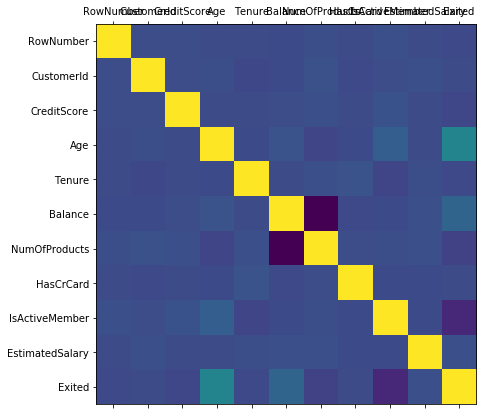

In [10]:

def plot_corr(df, size=7):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size,size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)
plot_corr(df)

Как видим из графика взаимосвязей никаких нет

Датафрейм df содержит следующие столбцы

Признаки:

- индекс строки в данных

- уникальный идентификатор клиента

- фамилия

- кредитный рейтинг

- страна проживания

- пол

- возраст

- количество недвижимости у клиента

- баланс на счёте

- количество продуктов банка, используемых клиентом

- наличие кредитной карты

- активность клиента

- предполагаемая зарплата

Целевой признак - факт ухода клиента («ушел» — 1, «не ушел» — 0). В этом заключается наша задача классификации, т.к. целевой признак является категориальным.

Первые три столбца не должны повлиять на принятие решения по уходу из банка, и их можно будет удалить из датасета 

Масштаб признаков разный, поэтому, перед тем как приступить к обучению модели, необходимо их масштабировать.


В датасете имеются как категориальные так и количественные признаки

Выполним предоработку:

In [11]:
#отделим слова нижним подчёркиванием, регистр текста заменим на нижний.
df.columns = df.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]
df.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Удалим столбцы, в которых нет необходимости

In [12]:
df = df.drop(['row_number','customer_id','surname'], axis=1)

In [13]:
#изменим тип данных у столбца  tenure и заполним пустые значения с помощью SimpleImputer из библиотеки sklearn
df['tenure'] = df['tenure'].replace(np.NaN, None).astype(int,errors='ignore').astype(object)
imputer = SimpleImputer(strategy='constant')
imp_data = pd.DataFrame(imputer.fit_transform(df))
imp_data.columns = df.columns

#проверим как сработал SimpleImputer
df['tenure'].isnull().sum()


0

In [14]:
df['tenure'].unique()

array([2, 1, 8, 7, 4, 6, 3, 10, 5, 9, 0], dtype=object)

In [15]:
df['tenure'].isna().sum()

0

In [16]:
#Проведем кодирование с помощью OHE
df = pd.get_dummies(df, drop_first=True)

#Стандартизируем признаки с помощью StandardScaler
scaler = StandardScaler()
numeric = ['credit_score', 'age', 'balance', 'estimated_salary']
scaler.fit(df[numeric])
df[numeric] = scaler.transform(df[numeric])

In [17]:
df

,credit_score,age,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,...,tenure_1,tenure_2,tenure_3,tenure_4,tenure_5,tenure_6,tenure_7,tenure_8,tenure_9,tenure_10
0,-0.326221,0.293517,-1.225848,1,1,1,0.021886,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,-0.440036,0.198164,0.117350,1,0,1,0.216534,0,0,1,...,1,0,0,0,0,0,0,0,0,0
2,-1.536794,0.293517,1.333053,3,1,0,0.240687,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.501521,0.007457,-1.225848,2,0,0,-0.108918,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,2.063884,0.388871,0.785728,1,1,1,-0.365276,0,0,1,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.246488,0.007457,-1.225848,2,1,0,-0.066419,0,0,0,...,0,0,0,0,1,0,0,0,0,0
9996,-1.391939,-0.373958,-0.306379,1,1,1,0.027988,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9997,0.604988,-0.278604,-1.225848,1,0,1,-1.008643,1,0,0,...,0,0,0,0,0,0,1,0,0,0
9998,1.256835,0.293517,-0.022608,2,1,0,-0.125231,1,1,0,...,0,0,1,0,0,0,0,0,0,0


In [18]:
#Разделим наш датасет на выборки в соотношении 3:1:1 и посмотрим их размер
X = df.drop(['exited'], axis=1)
y = df['exited']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.6, test_size=0.4, random_state=12345)
X_test, X_valid, y_test, y_valid = train_test_split(X_valid, y_valid, test_size=0.5, random_state=12345)

print('Размер обучающей выборки:', X_train.shape[0])
print('Размер валидационной выборки:', X_valid.shape[0])
print('Размер тестовой выборки:',X_test.shape[0])

Размер обучающей выборки: 6000
Размер валидационной выборки: 2000
Размер тестовой выборки: 2000


**Вывод**

 - изучили данные
 - нашли пустые значения в столбце tenure, заполнили их с помощью SimpleImputer
 - дубликатов не выявили
 - изучили  матрицу корреляции, никаких взаимосвязей потенциально мешающим будущим моделям не выявили
 - провели кодирование и стандартизировали 
 - разделили наш датасет на выборки : обучающую, валидационную и тестовую в соотношении 3:1:1

## Исследование задачи

В рамках проекта нам предстоит решить задачу бинарной классификации: спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. 

Перед тем, как приступить к задаче, необходимо:

 - исследовать баланс классов
 - обучить модели без учёта дисбаланса.

Проверим баланс классов.

In [19]:
values = df['exited'].value_counts()
values = values.to_frame().reset_index()
values.columns = ['Boolean', 'Count']
values['Percentage'] = df['exited'].value_counts(normalize=True)
pd.DataFrame(values)
values

,Boolean,Count,Percentage
0,0,7963,0.7963
1,1,2037,0.2037


Классы не сбалансированы.

Обучим разные модели без учёта дисбаланса. Так как нам предстоит решить задачу бинарной классификации, рассмотрим следующие модели:

In [20]:
# Модель RandomForestClassifier со стандартными параметрами
model = RandomForestClassifier(random_state=12345)
model.fit(X_train, y_train)
predicted_valid = model.predict(X_valid)
accuracy_valid = accuracy_score(predicted_valid, y_valid)
print('Accuracy is:', accuracy_valid)
print('F1_Score is:', f1_score(y_valid, predicted_valid))
confusion_matrix(y_valid, predicted_valid)

Accuracy is: 0.8385
F1_Score is: 0.49922480620155035


array([[1516,   61],
       [ 262,  161]])

In [21]:
# Модель logisticRegression со стандартными параметрами
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(X_train, y_train)
predicted_valid = model.predict(X_valid)
accuracy_valid = accuracy_score(predicted_valid, y_valid)
print('Accuracy is:', accuracy_valid)
print('F1_Score is:', f1_score(y_valid, predicted_valid))

confusion_matrix(y_valid, predicted_valid)

Accuracy is: 0.789
F1_Score is: 0.2673611111111111


array([[1501,   76],
       [ 346,   77]])

**Вывод**

RandomForestClassifier показывает наилучшие результаты, будем работать с данной  моделью и попытаемся ее улучшить

## Борьба с дисбалансом

Существует несколько способов борьбы с дисбалансом, в рамках данного проекта применим следующие:

 - взвешивание классов (объектам редкого класса придается больший вес)
 - увеличение выборки (upsampling)
 - уменьшение выборки (downsampling).

In [22]:
#class_weight='balanced'
for depth,estimator in itertools.product(range(1,30,10), range(1,151,50)):
    model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=estimator, class_weight='balanced')
    model.fit(X_train, y_train)
    predictions = model.predict(X_valid)
    score = accuracy_score(predictions, y_valid)
    fscore = f1_score(y_valid, predictions)
    print('Depth: {: >5.0f}       |   Estimators: {:>5.0f}'.format(depth, estimator))
    print('Accuracy: {: >5.4f}   |   F1_Score: {: >5.4f}'.format(score,fscore))


Depth:     1       |   Estimators:     1
Accuracy: 0.6785   |   F1_Score: 0.4819
Depth:     1       |   Estimators:    51
Accuracy: 0.7375   |   F1_Score: 0.4937
Depth:     1       |   Estimators:   101
Accuracy: 0.7345   |   F1_Score: 0.5238
Depth:    11       |   Estimators:     1
Accuracy: 0.7665   |   F1_Score: 0.5353
Depth:    11       |   Estimators:    51
Accuracy: 0.8350   |   F1_Score: 0.6034
Depth:    11       |   Estimators:   101
Accuracy: 0.8380   |   F1_Score: 0.6029
Depth:    21       |   Estimators:     1
Accuracy: 0.7605   |   F1_Score: 0.4437
Depth:    21       |   Estimators:    51
Accuracy: 0.8420   |   F1_Score: 0.5108
Depth:    21       |   Estimators:   101
Accuracy: 0.8425   |   F1_Score: 0.5116


При глубине деревьев 11 и числе деревьев 51  F1_score показывает наилучший результат : 0.6034 и accuracy_score : 0.8350. 



In [23]:
#увеличение выборки

def upsampling(features, target, repeat):
    X_zeros = X_train[y_train == 0]
    X_ones = X_train[y_train == 1]
    y_zeros = y_train[y_train == 0]
    y_ones = y_train[y_train == 1]

    X_upsampled = pd.concat([X_zeros] + [X_ones] * repeat)
    y_upsampled = pd.concat([y_zeros] + [y_ones] * repeat)
    
    X_upsampled, y_upsampled = shuffle(X_upsampled, y_upsampled, random_state=12345)
    
    return X_upsampled, y_upsampled


for repeat in range(1,10,1):
    X_upsampled, y_upsampled = upsampling(X_train, y_train, repeat)

    model = RandomForestClassifier(random_state=12345)
    model.fit(X_upsampled, y_upsampled)
    predictions = model.predict(X_valid)
    print("F1_Score: {: >5.3f}  |   Repeats : {: >5.0f}".format(f1_score(y_valid, predictions),repeat))

F1_Score: 0.496  |   Repeats :     1
F1_Score: 0.528  |   Repeats :     2
F1_Score: 0.506  |   Repeats :     3
F1_Score: 0.549  |   Repeats :     4
F1_Score: 0.533  |   Repeats :     5
F1_Score: 0.500  |   Repeats :     6
F1_Score: 0.524  |   Repeats :     7
F1_Score: 0.525  |   Repeats :     8
F1_Score: 0.526  |   Repeats :     9


Не добились показателя лучше предыдущего, уменьшим выборку

In [24]:
#уменьшение выборки

def downsampling(X, y, fraction):
    X_zeros = X[y == 0]
    X_ones = X[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]

    X_downsampled = pd.concat(
        [X_zeros.sample(frac=fraction, random_state=12345)] + [X_ones])
    y_downsampled = pd.concat(
        [y_zeros.sample(frac=fraction, random_state=12345)] + [y_ones])
    
    X_downsampled, y_downsampled = shuffle(
        X_downsampled, y_downsampled, random_state=12345)
    
    return X_downsampled, y_downsampled

for i in np.arange(0.03, 0.31, 0.03):
    X_downsampled, y_downsampled = downsampling(X_train, y_train, i)
    model = RandomForestClassifier(random_state=12345)
    model.fit(X_downsampled, y_downsampled)
    predictions = model.predict(X_valid)
    print("F1_Score: {: >5.3f}  |  Fractions : {: >5.3f}".format(f1_score(y_valid, predictions), i))

F1_Score: 0.374  |  Fractions : 0.030
F1_Score: 0.438  |  Fractions : 0.060
F1_Score: 0.473  |  Fractions : 0.090
F1_Score: 0.489  |  Fractions : 0.120
F1_Score: 0.503  |  Fractions : 0.150
F1_Score: 0.542  |  Fractions : 0.180
F1_Score: 0.535  |  Fractions : 0.210
F1_Score: 0.557  |  Fractions : 0.240
F1_Score: 0.534  |  Fractions : 0.270
F1_Score: 0.568  |  Fractions : 0.300


**Вывод:**

Через цикл попробовали методом подбора количества деревьев и глубины леса подобрать нужные параметры. 

Выявили лучшие параметры при взвешивании классов: глубина - 11, количество деревьев - 51,  F1 score показывает значение -  0.6034

Путем увеличения и уменьшения выборок  увеличить f1_score не удалось.

## Тестирование модели

In [25]:
# пробуем модель на тестовой выборке с соответствующими параметрами
model = RandomForestClassifier(n_estimators = 51, max_depth=11, class_weight='balanced', random_state=12345)
model.fit(X_train, y_train)
predicted_valid = model.predict(X_test)

accuracy_valid = accuracy_score(predicted_valid, y_test)
print('Accuracy is:', accuracy_valid)
print('F1_Score is:', f1_score(y_test, predicted_valid))

Accuracy is: 0.843
F1_Score is: 0.6244019138755981


Получили достаточное значение f1

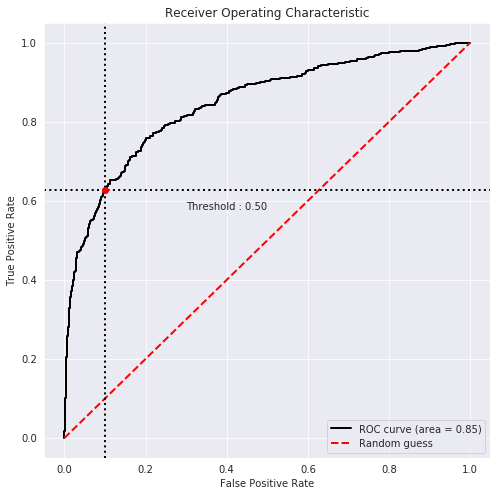

                       Roc Auc Score is: 0.847




In [26]:
#рисуем ROC кривую
y_pred = model.predict_proba(X_test)[:,1]
bc = BinaryClassification(y_test, y_pred, labels=["Class 1"])

plt.figure(figsize=(8,8))
bc.plot_roc_curve()
plt.show()
print('                       Roc Auc Score is: {:.3f}'.format(roc_auc_score(y_test, y_pred)))
print('\n')

**Вывод**

Целью проекта было построение модели с предельно большим значением F1-меры (больше 0.59). 

В ходе решения поставленной задачи мы подготовили датасет для прогнозирования оттока клиентов.

Использовали две модели : RandomForestClassifier и LogisticRegression. 
Выбрали модель RandomForestClassifier для дальнейшей работы, так как изначально она показала лучшие результаты.

Через цикл попробовали методом подбора количества деревьев и глубины леса подобрать нужные параметры.
Выявили лучшие параметры при взвешивании классов: глубина - 11, количество деревьев - 51, F1 score показывает значение - 0.6034


Отрисовали ROC кривую и получили roc auc score : 0.85, что значительно больше случайного порога в 0.5. 
Наша модель предсказывает достаточно хорошо, так как проверив модель на тестовой выборке мы получили требуемое значение.

Поставленная задача выполнена.